# **DEEP LEARNING**
*APLICACIÓN DE UNA RED CONVOLUCIONAL*

Proyecto: Algoritmo entrenado a partir de una red convolucional capaz de clasificar imágenes de gatitos y perritos

By:Brandon Yahir Arriaga Tlapa

### **Documentación sobre el dataset**
https://www.kaggle.com/competitions/dogs-vs-cats/data


20,000 imágenes de entrenamiento y 5,000 imágenes de validación.



## **Carga de librerias**

In [1]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## **Obtención del data set en Google Colaboratory**

In [3]:
# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir rutas
drive_path = '/content/drive/MyDrive/'  # Ruta base
zip_path = os.path.join(drive_path, 'Dogs vs Cats/train.zip')  # Ruta al ZIP en Drive
extract_dir = '/content/dataset'  # Extraeremos en el entorno de Colab
output_dir = os.path.join(extract_dir, 'train')  # Carpeta organizada

# 3. Extraer el archivo ZIP
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 4. Organizar las imágenes en carpetas por clase
dataset_dir = os.path.join(extract_dir, 'train')
# Crear subcarpetas para cada clase
os.makedirs(os.path.join(output_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'dog'), exist_ok=True)

# Mover imágenes a las carpetas correspondientes
for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'):
        if 'cat' in filename.lower():
            shutil.move(os.path.join(dataset_dir, filename),
                       os.path.join(output_dir, 'cat', filename))
        elif 'dog' in filename.lower():
            shutil.move(os.path.join(dataset_dir, filename),
                       os.path.join(output_dir, 'dog', filename))

# 5. Configurar generadores de imágenes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Generador para entrenamiento
train_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

# Generador para validación
validation_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


print(f"Número de imágenes de entrenamiento: {train_generator.samples}")
print(f"Número de imágenes de validación: {validation_generator.samples}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
¡Configuración completada!
Número de imágenes de entrenamiento: 20000
Número de imágenes de validación: 5000


## **Visualización y Exploración de Datos**

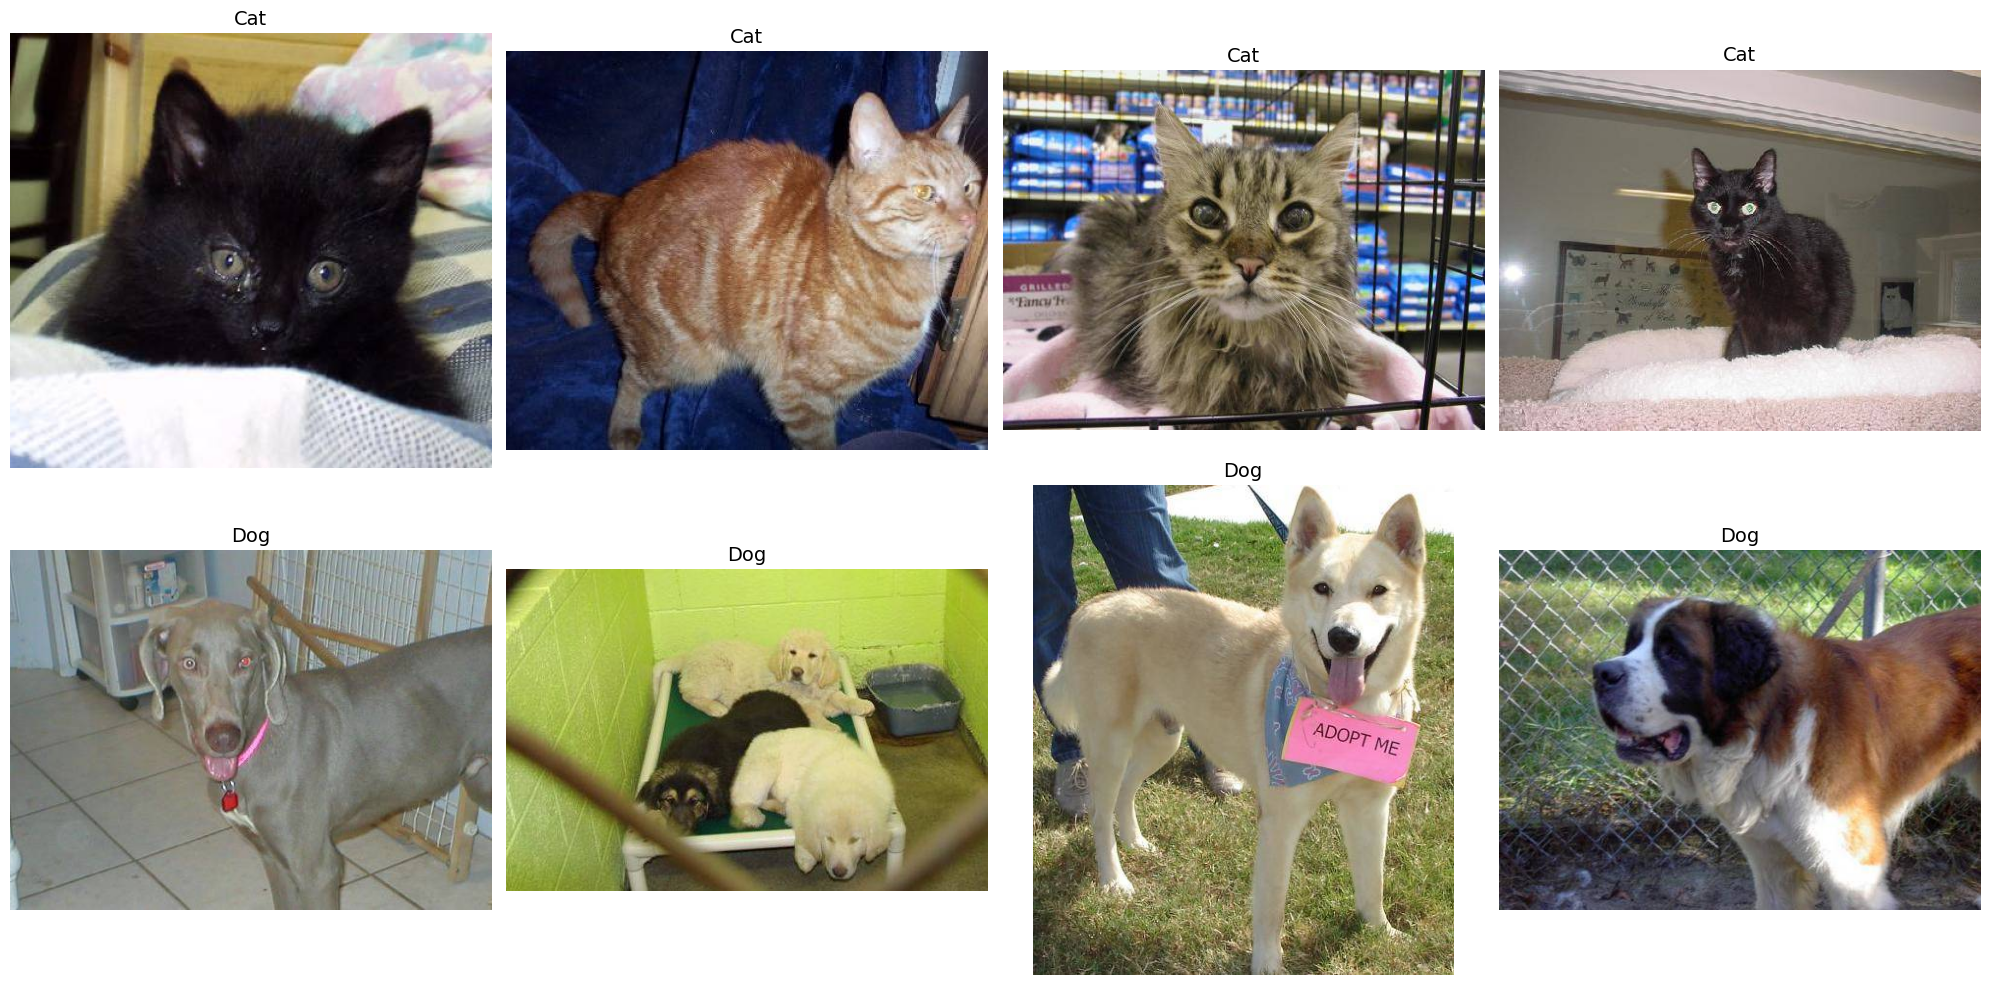

In [4]:
#displaying 4 images for each class
cat_images = []
dog_images = []

for filename, label in zip(train_generator.filenames, train_generator.labels):
    img_path = os.path.join(train_generator.directory, filename)
    if label == 0:
        cat_images.append(img_path)
    elif label == 1:
        dog_images.append(img_path)
    if len(cat_images) >= 4 and len(dog_images) >= 4:
        break

images_to_display = cat_images[:4] + dog_images[:4]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    img = image.load_img(images_to_display[i])
    ax.imshow(img)
    ax.axis('off')
    if i < 4:
        ax.set_title("Cat", fontsize=14)
    else:
        ax.set_title("Dog", fontsize=14)
plt.tight_layout()
plt.show()

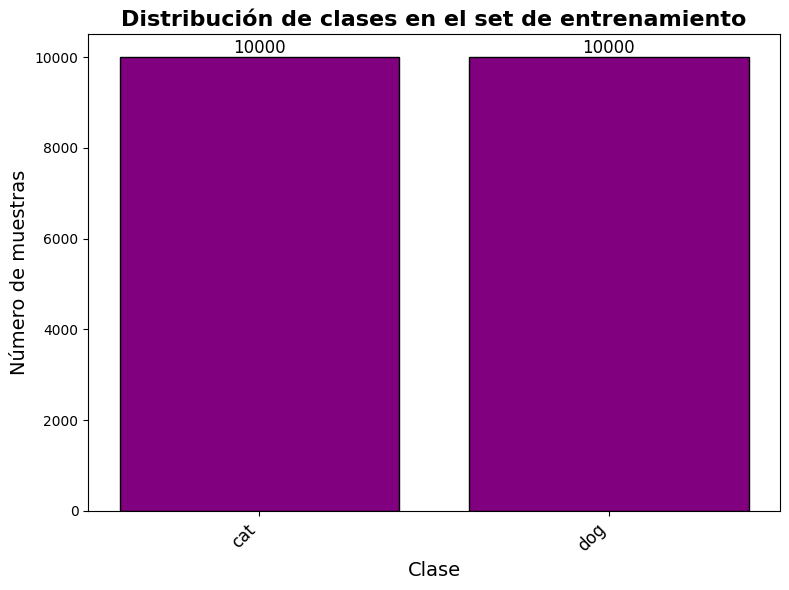

In [8]:
#class distribution
class_labels = list(train_generator.class_indices.keys())
train_class_counts = [list(train_generator.labels).count(i) for i in range(len(class_labels))]

plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, train_class_counts, color='purple', edgecolor='black')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=12)
plt.title('Distribución de clases en el set de entrenamiento', fontsize=16, fontweight='bold')
plt.xlabel('Clase', fontsize=14)
plt.ylabel('Número de muestras', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# Definir el modelo CNN
def cnn_model():
    model = Sequential([
        # Capa convolucional 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        # Capa convolucional 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Capa convolucional 3 (añadida para mejor rendimiento)
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Aplanar y capas densas
        Flatten(),
        Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Regularización
        Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo con learning rate ajustable
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                          tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()])
    return model

# Crear e instanciar el modelo
custom_cnn_model = cnn_model()
custom_cnn_model.summary()

# Entrenar el modelo con callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = custom_cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # Aumentamos las épocas
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 308s 485ms/step - accuracy: 0.5659 - loss: 0.7339 - precision: 0.5728 - recall: 0.5205 - val_accuracy: 0.6196 - val_loss: 0.6355 - val_precision: 0.5843 - val_recall: 0.8288 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 299s 479ms/step - accuracy: 0.6438 - loss: 0.6313 - precision: 0.6548 - recall: 0.6189 - val_accuracy: 0.7172 - val_loss: 0.5649 - val_precision: 0.6989 - val_recall: 0.7632 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 304s 486ms/step - accuracy: 0.6994 - loss: 0.5783 - precision: 0.7181 - recall: 0.6584 - val_accuracy: 0.7080 - val_loss: 0.5615 - val_precision: 0.7985 - val_recall: 0.5564 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 304s 486ms/step - accuracy: 0.7202 - loss: 0.5489 - precision: 0.7288 - recall: 0.7001 - val_accuracy: 0.7650 - val_loss: 0.5009 - val_precision: 0.7780 - val_recall: 0.7416 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 300s 480

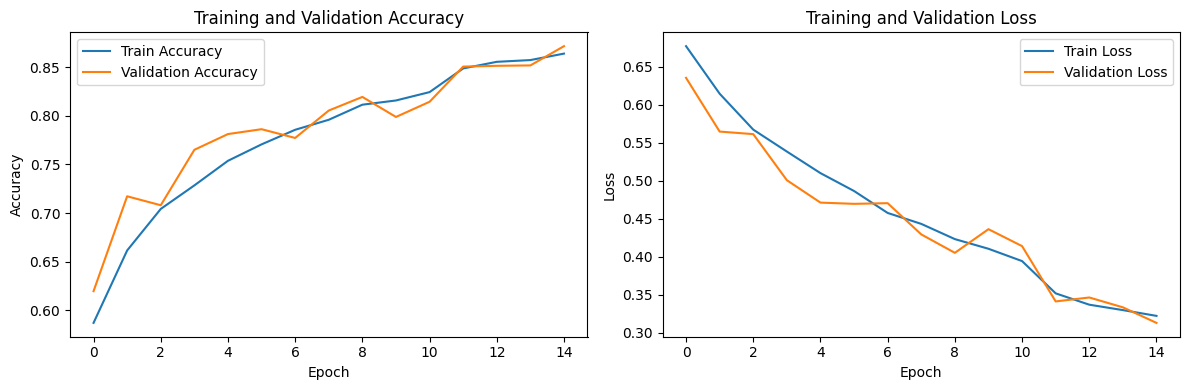

157/157 ━━━━━━━━━━━━━━━━━━━━ 57s 365ms/step - accuracy: 0.8668 - loss: 0.3238 - precision: 0.8713 - recall: 0.8650

Validation Accuracy: 86.80%
Precision: 87.70%
Recall: 85.60%


In [11]:
# Visualizar el rendimiento
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluar el modelo
loss, accuracy, precision, recall = custom_cnn_model.evaluate(validation_generator)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

In [18]:
#making predictions on some sample data
sample_images, sample_labels = next(validation_generator)
predictions = custom_cnn_model.predict(sample_images)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


## **Visualización del clasificador en un conjunto de datos muestra**

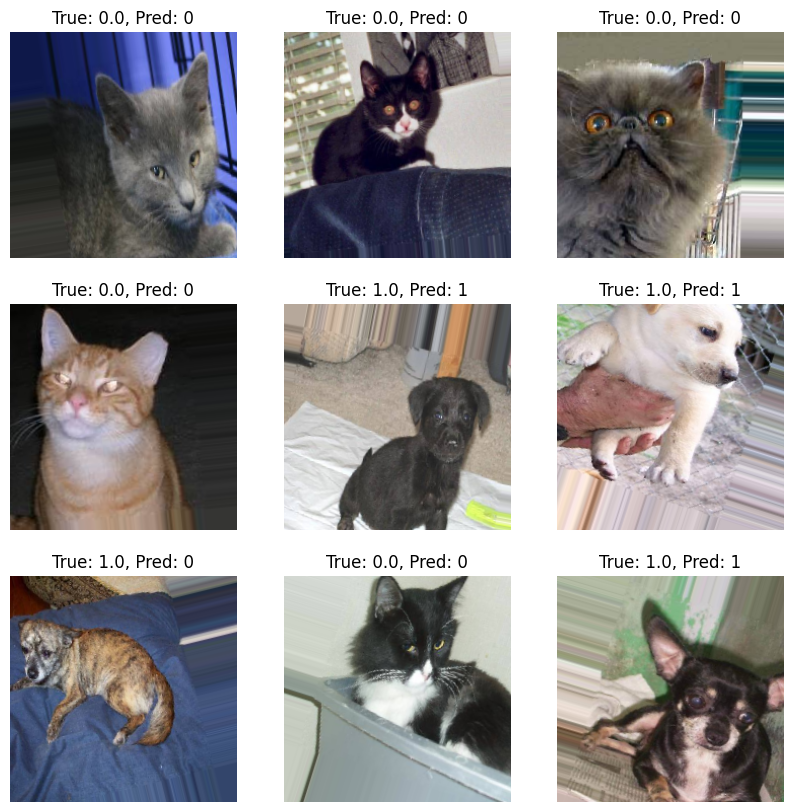

In [19]:
#displaying sample images and their predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f'True: {sample_labels[i]}, Pred: {predicted_labels[i]}')
    plt.axis('off')
plt.show()

# **Métricas Generales del Modelo**

In [22]:
y_true_classes = sample_labels
y_pred_classes = predicted_labels
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.88      0.91        17
         1.0       0.88      0.93      0.90        15

    accuracy                           0.91        32
   macro avg       0.91      0.91      0.91        32
weighted avg       0.91      0.91      0.91        32

